In [ ]:
# WFLWのアノテーションデータの読み込み
annotation_data_path = "/root/dataset/WFLW/WFLW_annotations/list_98pt_rect_attr_train_test/list_98pt_rect_attr_train.txt"

with open(annotation_data_path) as f:
    # anotation_data = f.read()
    anotation_data = f.readlines()
    # print(anotation_data)
# print(type(anotation_data))
# print(anotation_data)

anotation_data_lists = []
for i in anotation_data:
    anotation_data_lists.append(i.split(" "))

bounding_box_data (306, 308, 696, 870)
[ 3.307007 11.857345 16.271739 13.583872  8.765287  7.308619  9.648163
 16.526266 25.880068 36.087363]
[230.369019 252.120847 275.014395 298.149851 321.015727 344.33149
 367.558182 389.876907 411.301121 432.336765]
画像サイズ： (390, 562)


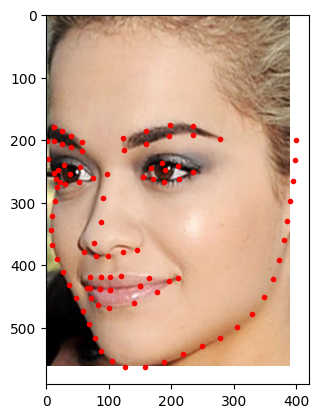

In [5]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

image_num = 0
WFLW_images = "/root/dataset/WFLW/WFLW_images"
image_path = WFLW_images + "/" + anotation_data_lists[image_num][-1].replace("\n","")
bounding_box_data = tuple([int(bdbox) for bdbox in anotation_data_lists[image_num][-11:-7]])
keypoints_x = [float(keypoint) - bounding_box_data[0]   for keypoint in anotation_data_lists[image_num][0:196:2]]
keypoints_y = [float(keypoint) - bounding_box_data[1]  for keypoint in anotation_data_lists[image_num][1:196:2]]

print("bounding_box_data",bounding_box_data)
x_np = np.array(keypoints_x)
y_np = np.array(keypoints_y)
print(x_np[0:10])
print(y_np[0:10])

fig,ax = plt.subplots(1)
image = Image.open(image_path)

image = image.crop(bounding_box_data)
print("画像サイズ：",image.size)
ax.imshow(image)
plt.plot(x_np, y_np, 'o',color='red',markersize=3)  # 点と点を線でつなぐプロットを作成
plt.show()

In [ ]:
import cv2
import numpy as np

import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables import Keypoint, KeypointsOnImage


def AugmentFaceKeypointDataset(training_samples, data_path, aug_data_num):
    data_set_list = []
    for data_num in range(training_samples.shape[0]):
        # image = cv2.imread(f"{data_path}/{training_samples.iloc[data_num, 0]}")
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # orig_h, orig_w, _ = image.shape
        # image = cv2.resize(image, (config.RESIZE, config.RESIZE))
        # About keypoint
        keypoints = training_samples.iloc[data_num][1:]
        keypoints = np.array(keypoints, dtype="float32")
        keypoints = keypoints.reshape(-1, 2)
        keypoints_per = keypoints * [1 / (orig_w), 1 / (orig_h)]
        data_set_list.append([image, keypoints_per])

        # データ拡張枚数が0枚の場合はデータ拡張の部分をスキップする
        if aug_data_num == 0:
            continue

        landmark_num = len(keypoints)
        kps = KeypointsOnImage(
            [Keypoint(x=keypoints[i][0], y=keypoints[i][1]) for i in range(0,landmark_num)],
            shape=image.shape,
        )

        seq = iaa.Sequential(
            [
                iaa.Affine(
                    rotate=(-80, 80)
                ),
                iaa.Fliplr(0.5), # 50%の確率で画像を反転させる
                iaa.ShearX((-10, 10)),
                iaa.ShearX((-20, 20)),
                iaa.Fliplr(0.5)
            ]
        )
        
        aug = iaa.Resize({"height": 32, "width": 64})
        
        for aug_count in range(aug_data_num-1):
            # print("データ拡張を行います")
            image_aug, kps_aug = seq(image=image, keypoints=kps)
            keypoints = []
            for i in range(len(kps.keypoints)):
                before = kps.keypoints[i]
                after = kps_aug.keypoints[i]
                keypoints.append([after.x, after.y])
            keypoints = np.array(keypoints, dtype="float32")
            keypoints_per = keypoints * [1 / (orig_w), 1 / (orig_h)]
            image_after = kps_aug.draw_on_image(image_aug, size=0)
            # データ拡張を行った画像をリストに格納する
            data_set_list.append([image_after, keypoints_per])
    print("len(data_set_list)",len(data_set_list))
    return data_set_list